##### Installing Julia packages (only needs to be done once)

In [ ]:
import Pkg;

Pkg.add(url="https://github.com/Marc-3d/LIBTIFF.jl.git")
Pkg.add(url="https://github.com/Marc-3d/multi_quickPIV.git")
Pkg.add(url="https://github.com/Marc-3d/ImageAnalysis.git")

# VISUALIZATION PACKAGES
#   PyPlot is very popular and great for generating non-interactive Plots
#   ImageView a simple visualization package, similar to Fiji, allowing to scroll through timepoints in a 2D+t dataset
#   Makie is great for interactive visulization, but it is a big package. It might take a bit to install/compile.

Pkg.add("PyCall")
Pkg.add("PyPlot")
Pkg.add("ImageView")
Pkg.add("Makie") 

# IMAGE PROCESSING and IMAGE-RELATED PACKAGES
Pkg.add("Images")
Pkg.add("ImageMorphology")
Pkg.add("ImageComponentAnalysis")
Pkg.add("ImageDraw")
Pkg.add("ColorTypes")
Pkg.add("ColorSchemes")
Pkg.add("DistanceTransforms")

##### Importing Julia packages

In [2]:
using LIBTIFF, FileIO, JLD2
using multi_quickPIV, ImageAnalysis
using GLMakie, ImageView, PyPlot, PyCall
using Images, ImageMorphology, ImageComponentAnalysis, ImageDraw, ColorTypes, DistanceTransforms, ColorSchemes

# importing pipeline scripts 
script_path = joinpath( pwd(), "scripts" ); 
include( joinpath( script_path, "vf_utils.jl" ) )
include( joinpath( script_path, "wave_utils.jl" ) )
include( joinpath( script_path, "makie_utils.jl" ) )
include("wave_segmentation_Pereyra_etal.jl")


(process:187972): Gdk-WARNING **: 14:43:42.529: Could not open registry key 'SYSTEM\CurrentControlSet\Control\Keyboard Layouts\A0000C0A'. Error code: 2

(process:187972): Gdk-WARNING **: 14:43:42.529: Could not open registry key 'SYSTEM\CurrentControlSet\Control\Keyboard Layouts\(NULL)'. Error code: 2

(process:187972): Gdk-WARNING **: 14:43:42.529: Failed to load keyboard layout DLL for layout A0000C0A: (NULL)


paint_VD! (generic function with 1 method)

##### Loading pre-computed results

Loading the following data form ```cylinder_2Dt_results.jld2```. <br>
* cylinder projections
* projection distorsions
* PIV vector fields

In [3]:
jld2_dir    = ""; 
jld2_dir    = "R:/users/pereyram/SHARING/Wave_detection_paper_movies/"
jld2_path   = joinpath( jld2_dir, "cylinder_2Dt_results.jld2" ); 
    
cylinder_2Dt    = load( jld2_path, "cylinder_projections" );
mag_distorsions = load( jld2_path, "distorsions" );
filt_PIVs       = load( jld2_path, "filtered PIVs" ); 
pivparams       = multi_quickPIV.setPIVParameters( interSize=64, searchMargin=32, step=16 );

# printing information about the cylinder projection data 

n_im_tps = size( cylinder_2Dt,3); 
im_size  = size( cylinder_2Dt )[1:2]; 

n_vf_tps = length( filt_PIVs ); 
vf_dims  = size( filt_PIVs[1], 1 ); 
vf_size  = size( filt_PIVs[1] )[2:end]; 

println( "Loaded $(n_vf_tps) $(vf_dims)-D vector fields of size: $(vf_size)" ); 
println( "Loaded $(n_im_tps) images of size: $(im_size)" ); 

Loaded 99 2-D vector fields of size: (191, 55)
Loaded 100 images of size: (3114, 941)


In [4]:
visualize_data = true

if visualize_data
    
    clim = ImageView.default_clim( ones( Float32, 1, 1 ) .* ( 1, 300 ) )
    ImageView.imshow(  cylinder_2Dt, clim ); 
end

Dict{String, Any} with 4 entries:
  "gui"         => Dict{String, Any}("window"=>GtkWindowLeaf(Ptr{GObject} @0x00…
  "roi"         => Dict{String, Any}("redraw"=>ObserverFunction[ObserverFunctio…
  "annotations" => Observable(Dict{UInt64, Any}())
  "clim"        => Observable(CLim{Float32}(1.0, 300.0))

##### Computing reference vectors for each VF position

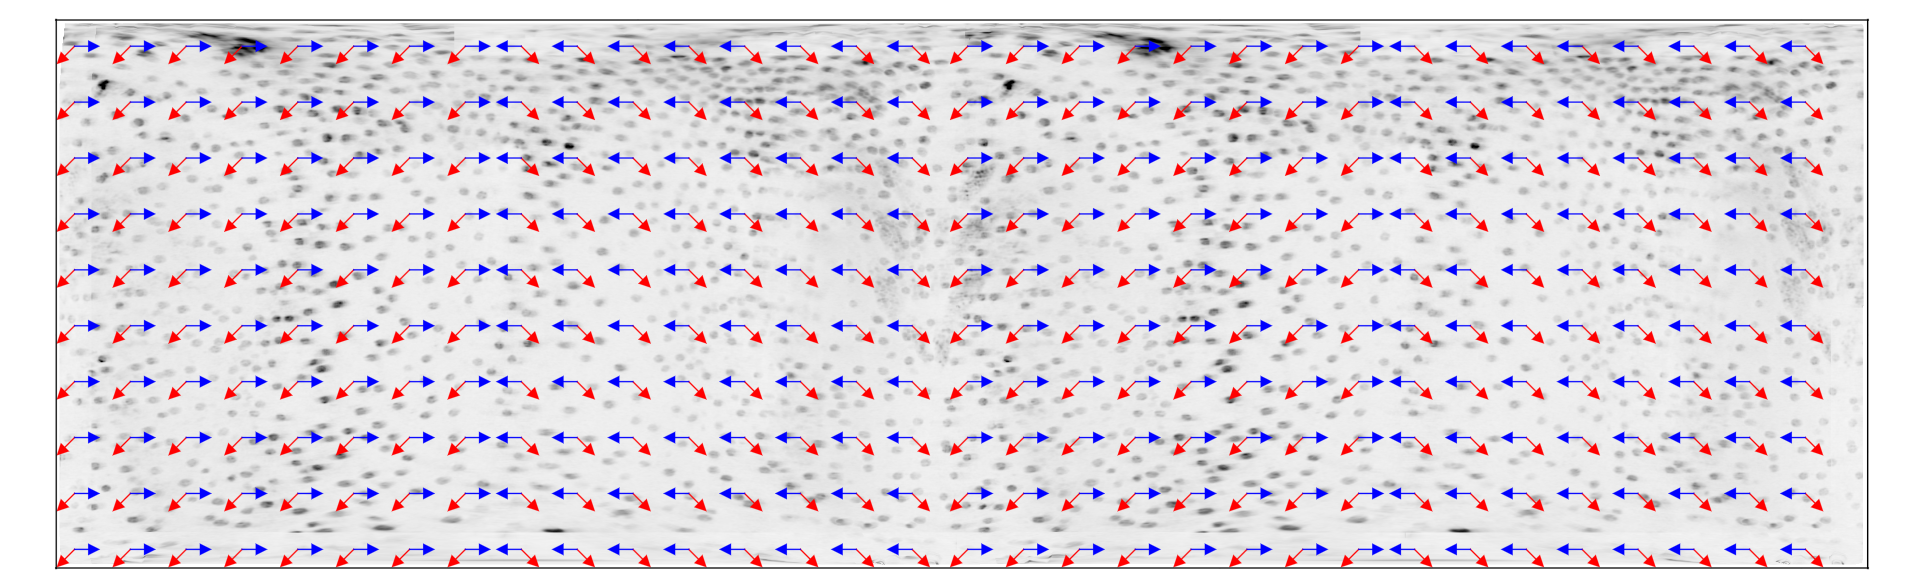

GLMakie.Screen(...)

In [5]:
#=

Julia is a column-first programming language. Confusingly enough, this means that the vertical axis (rows) is 
the first (and fastest-varying) dimension of julia arrays, and the horizontal axis (columns) is the second 
dimension. We stick to this convention in quickPIV too: the U components of PIV vectors corresponds to the
vertical displacements, and the V components to the horizontal displacements. The same convention is used to 
define the reference vectors. 

The cylinder projections are oriented "vertically" with the longest axis (dorsoventral) in the first dimension.
Therefore, the first component of the ventral and dorsal reference vectors needs to be adapted to always point
towards the ventral side (the face) of the embryo. 

Below, you have a schematic of the cylinder projections, and a description of the components of the reference 
vectors. Notice that the first dimension of the reference vectors has to "flip", according to the relative 
position of the vector's position with respect to the face of the embryo. 

 (1,1)      (1,W)
     |-------|  dorsal                                                              
     |       |                                                                      
     |       |      -------> reference ventral vector: rv_U =  cosd(-45) ( downward (+row) movement at 45º )          
     |       |                                         rv_V =  sind(-45) ( leftward (-col) movmeent at 45º ) 
     |       |                                                                      
     |       |      -------> reference dorsal  vector: rd_U = -cosd( 0 ) (   updward (-row) movement at 0º )          
     |       |                                         rd_V =  sind( 0 ) (      no horizontal movement     )                                                                      
     |       |                                                                      
     |    (: |  ventral                                                              
     |       |                                                                      
     |       |      -------> reference ventral vector: rv_U = -cosd(-45) (   upward (-row) movement at 45º )          
     |       |                                         rv_V =  sind(-45) ( leftward (-col) movmeent at 45º ) 
     |       |                                                                      
     |       |      -------> reference dorsal  vector: rd_U =  cosd( 0 ) (  downward (+row) movement at 0º )          
     |       |                                         rd_V =  sind( 0 ) (      no horizontal movement     )        
     |       |                                                                      
     |-------|  dorsal
 (H,1)      (H,W)

=#

α_ventral   = 45
α_dorsal    = 0
ref_ventral = ( cosd( -α_ventral ), sind( -α_ventral ) )
ref_dorsal  = ( -cosd( α_dorsal  ), sind( α_dorsal   ) )

# Creating a vector field with adapted ventral and dorsal reference vectors. We do this by flipping the 
# U component of the reference vectors when needed

VF_ref_ventral = zeros( Float32, 2, vf_size... )
VF_ref_dorsal  = zeros( Float32, 2, vf_size... )

for x in 1:vf_size[2]
    flip_u = -1
    for y in 1:vf_size[1]
        flip_u = ( rem( y, div(vf_size[1],4) ) == 0  ) ? flip_u * -1 :  flip_u
        
        VF_ref_ventral[ 1, y, x ] = ref_ventral[1]  * flip_u
        VF_ref_ventral[ 2, y, x ] = ref_ventral[2]
        
        VF_ref_dorsal[ 1, y, x ] = ref_dorsal[1]  * flip_u
        VF_ref_dorsal[ 2, y, x ] = ref_dorsal[2]
    end
end

# Visualizing the vector fields. 

IA = pivparams.interSize[1:2]
ST = pivparams.step[1:2]

vf_subsample  = (6,6)
yrange_sub    =  1:vf_subsample[1]:vf_size[1]
xrange_sub    =  1:vf_subsample[2]:vf_size[2]
ygrid_sub     = [ ( y - 1 )*ST[1] + div(IA[1],2) for y in yrange_sub ]
xgrid_sub     = [ ( x - 1 )*ST[2] + div(IA[2],2) for x in xrange_sub ]
U_ref_ventral = VF_ref_ventral[ 1, yrange_sub, xrange_sub ]
V_ref_ventral = VF_ref_ventral[ 2, yrange_sub, xrange_sub ]
U_ref_dorsal  = VF_ref_dorsal[  1, yrange_sub, xrange_sub ]
V_ref_dorsal  = VF_ref_dorsal[  2, yrange_sub, xrange_sub ]

Makie.inline!(true)
f  = GLMakie.Figure( size = div.( im_size, 2 ), backgroundcolor = :white, dpi=150 )
a1 = GLMakie.Axis( f[1,1], backgroundcolor = "black", aspect=DataAspect() )
hidedecorations!( a1, grid = false )
GLMakie.image!(  a1, min.( cylinder_2Dt[:,:,1], 400 ), colormap=:binary )
GLMakie.arrows!( a1, ygrid_sub, xgrid_sub, U_ref_ventral, V_ref_ventral, arrowsize = 13, lengthscale = 30, arrowcolor = :red , linecolor = :red  )
GLMakie.arrows!( a1, ygrid_sub, xgrid_sub, U_ref_dorsal , V_ref_dorsal , arrowsize = 13, lengthscale = 30, arrowcolor = :blue, linecolor = :blue )
display( f )

##### Wave detection

In [6]:
# smoothing the vector field before wave detection

filt_PIVs_mat = zeros( eltype( filt_PIVs[1] ), size( filt_PIVs[1] )..., length( filt_PIVs ) )
for t in 1:length(filt_PIVs)
    filt_PIVs_mat[:,:,:,t] .= filt_PIVs[t]
end
smooth_PIVs_mat = smooth( (1,1,1), filt_PIVs_mat );
smooth_PIVs     = [ smooth_PIVs_mat[:,:,:,i] for i in 1:size(smooth_PIVs_mat,4) ]

# wave detection 

wave_params  = wave_parameters( dorsal_dir = (  1, 0 ),
                               ventral_dir = ( -1, 0 ), # this will be overwritten
                                   top_dir = (  0, 1 ),
                                  max_ref_angle = 50,
                                      min_angle = 30,
                              max_V_intra_angle = 40, 
                              max_D_intra_angle = 40,
                                  min_top_angle = 0, 
                                    D_min_speed = 1.0, 
                                    V_min_speed = 1.0, 
                                    V_avg_speed = 3, 
                               min_displacement = 10
                              )

wave_PIVs  = [ ( vf[1,:,:] .* mag_distorsions[1], vf[2,:,:] .* mag_distorsions[2] ) for vf in smooth_PIVs ]; 
U_override = VF_ref_ventral[1,:,:], VF_ref_dorsal[1,:,:]; 
V_override = VF_ref_ventral[2,:,:], VF_ref_dorsal[2,:,:]; 

@time WVs = detect_waves( wave_PIVs, wave_params,
                          vec_override=true, U_override=U_override, V_override=V_override,
                          r_max=10 );

filt_WVs = post_process_cylinder_waves( WVs ); 
smth_WVs = smooth_waves.( filt_WVs, th=0.7 ); 

 10.683980 seconds (48.95 M allocations: 2.369 GiB, 3.72% gc time, 29.16% compilation time)


In [7]:
visualize_waves = true

if visualize_waves
    
    mp           = PyCall.pyimport( "matplotlib" )
    cmap         = mp.cm.get_cmap("RdYlBu_r")
    colors_      = [ Colors.RGBA{Float64}(cmap(x)[1:3]..., x != 0.5) for x in [ 0.0, 0.5, 1.0 ] ]
    colorscheme_ = ColorScheme( colors_ )
    
    Makie.inline!(false)
    scrollable_vectorfield( format_VFs(  filt_PIVs ), 
                            format_IMGs( cylinder_2Dt, maxI=400 ), 
                            format_WVs(  smth_WVs, size(cylinder_2Dt)[1:2] ),
                            IA=(64,64), step=(16,16), 
                            cmap_data=:binary, arrow_color=:black, cmap_overlay=colorscheme_ )
end

GLMakie.Screen(...)

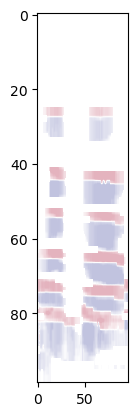

PyObject <matplotlib.image.AxesImage object at 0x0000023AF64666D0>

In [8]:
vf_size = size( filt_PIVs[1] )[2:end]
ygrid = [ ( y - 1 )*ST[1] + div(IA[1],2) for y in 1:vf_size[1] ]
xgrid = [ ( x - 1 )*ST[2] + div(IA[2],2) for x in 1:vf_size[2] ]

wave_1_v, wave_2_v = kymographs( [ Float32.( wv .==  1 ) for wv in filt_WVs ], fun=(x)->(sum(x)/length(x)));
wave_1_d, wave_2_d = kymographs( [ Float32.( wv .== -1 ) for wv in filt_WVs ], fun=(x)->(sum(x)/length(x)));

wave_1 = zeros( Float32, size( wave_1_v ) )
for i in 1:length( wave_1_v )
    v_ = wave_1_v[i]
    d_ = -wave_1_d[i]
    wave_1[i] = abs( v_ ) > abs( d_ ) ? v_ : d_ 
end

ymask = collect( 1:vf_size[1] )[ 780 .<= ygrid .<= 2335 ]

kimg = wave_1[ ymask, : ]
kimg = kimg ./ ( abs.( kimg ) .> 0.0 ); 
PyPlot.figure( dpi=100 )
colors_ = [ (193/255,195/255,223/255), (1.0,1.0,1.0), (228/255,179/255,190/255) ] 
cmarc = mp.colors.LinearSegmentedColormap.from_list( "marc", colors_, N=256 ) 
PyPlot.imshow( kimg', aspect=4, cmap=cmarc, alpha=1.0, vmin=-0.5, vmax=0.5 ) 

##### Divergence

In [9]:
# COMPUTING DIVERGENCES

divg_radius = (8,8)
divergences = []

cart_size = size( cylinder_2Dt[:,:,1] )
for t in 1:length( filt_PIVs )
    print( t, "," )
    divergence_ = multi_quickPIV.divergence( divg_radius, smooth_PIVs[t], normalize=false, min_speed=1.0, divide_by="N" );
    divergence_[  divergence_ .== Inf  ] .= 0.0
    divergence_[ isnan.( divergence_ ) ] .= 0.0
    push!( divergences, divergence_ )
end

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,

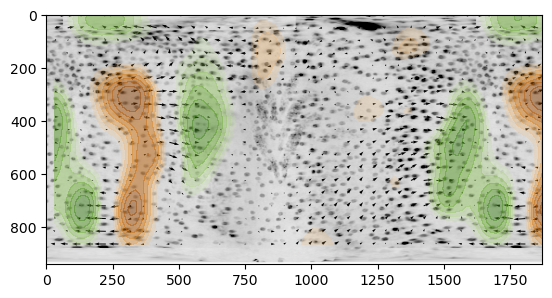

PyObject <matplotlib.contour.QuadContourSet object at 0x0000023B13847C10>

In [11]:
# PYPLOT VISUALIZATION OF DIVERGENCE

using PyPlot, Images, ColorSchemes, PyCall, Colors

np = PyCall.pyimport( "numpy" )

function divergence_colormap( ncolors=128 )

    bottom = matplotlib.cm.get_cmap("PiYG", ncolors)
    top    = matplotlib.cm.get_cmap("PuOr", ncolors)
    newcolors = np.vstack((top(np.linspace(0, 0.5, ncolors)),
                           bottom(np.linspace(0.5,1, ncolors))))
    N  = size( newcolors, 1 )
    N2 = div( N + 1, 2 )
    for i in 1:N
        frac  = ( i - N2 )/N2
        alpha = min( (abs(frac)>0.3)*abs(frac)^1.7, 0.5 )
        newcolors[i,end] = alpha
    end
    
    newcmp = matplotlib.colors.ListedColormap(newcolors, name="OrangeBlue")
    
    return newcmp
end

function transpose_cartography( cart )
    cart_t = zeros( eltype( cart ), size( cart )[end:-1:1] )
    for row in 1:size(cart,1)
        cart_t[:,row] .= cart[row,end:-1:1]
    end
    return cart_t
end

function visualize_cart_waves( cart, waves; frac=5, vmax=200, rad=3 )
    
    ksize = ones( Int, ndims(waves) ) .* ( 2 * rad + 1 ) 
    kern  = ones( Float32, ksize... ) ./ prod( ksize )
    W     = multi_quickPIV.FFTCC_crop( kern, Float32.( waves ) )
    W   .*= abs.( W ) .> 0.5

    wv_  = Images.imresize( W, size( cart ) )
    
    img_ = transpose_cartography( cart )
    wv_  = transpose_cartography( wv_  )
    wv_  = wv_ ./ abs.( wv_ )

    ilen = size( img_, 2 )
    PyPlot.imshow( img_[ :, div(ilen,frac):end-div(ilen,frac) ], cmap="gray_r", vmax=vmax )
    PyPlot.imshow( wv_[ :, div(ilen,frac):end-div(ilen,frac) ], alpha=0.3, vmin=-1, vmax=1, cmap="RdYlBu_r" )
end

function visualize_cart_waves( cart, waves, U, V; 
                               frac=5, 
                               vmax=200, 
                               rad=3, 
                               scale=40, width=0.008, color="black",
                               vf_limits=( div(size(U,1),frac):size(U,1)-div(size(U,1),frac), 1:size(U,2) ),
                               subsample=1,
                               vf_range=StepRange.( 1, subsample, length.(vf_limits) ), 
                               IA=(64,64), ST=(32,32) )

    ksize = ones( Int, ndims(waves) ) .* ( 2 * rad + 1 ) 
    kern  = ones( Float32, ksize... ) ./ prod( ksize )
    W     = multi_quickPIV.FFTCC_crop( kern, Float32.( waves ) )
    W   .*= abs.( W ) .> 0.5

    wv_  = Images.imresize( W, size( cart ) )
    
    img_ = transpose_cartography( cart )
    wv_  = transpose_cartography( wv_  )
    wv_  = wv_ ./ abs.( wv_ )
    U_ = U[ vf_limits... ]
    V_ = V[ vf_limits... ]
    U_ = U_[ vf_range... ]
    V_ = V_[ vf_range... ]
    M  = Float32.( sqrt.( V_ .^ 2 .+ U_ .^ 2 ) .> 0.5 )
    xx = [ div( IA[2], 2 ) + (x-1)*subsample*ST[2] for y in 1:size(U_,1), x in 1:size(U_,2) ]
    yy = [ div( IA[1], 2 ) + (y-1)*subsample*ST[1] for y in 1:size(U_,1), x in 1:size(U_,2) ]
    
    ilen = size( img_, 2 )
    I = img_[ :, div(ilen,frac):end-div(ilen,frac) ]
    W =  wv_[ :, div(ilen,frac):end-div(ilen,frac) ]
    
    PyPlot.imshow( I, cmap="gray_r", vmax=vmax )
    PyPlot.imshow( W, alpha=0.3, vmin=-1, vmax=1, cmap="RdYlBu_r" )
    PyPlot.quiver( yy, -1 .* xx .+ maximum(xx), U_ ./ M .* M, V_ ./ M .* M, color=color, width=width, scale=scale )
end

function visualize_cart_waves( cart, waves, U, V, divg; 
                               frac=5, 
                               vmax=200, 
                               rad=3, 
                               scale=40, width=0.008, color="black",
                               vf_limits=( div(size(U,1),frac):size(U,1)-div(size(U,1),frac), 1:size(U,2) ),
                               subsample=1,
                               vf_range=StepRange.( 1, subsample, length.(vf_limits) ), 
                               IA=(64,64), ST=(32,32), cmap=0 )

    ksize = ones( Int, ndims(waves) ) .* ( 2 * rad + 1 ) 
    kern  = ones( Float32, ksize... ) ./ prod( ksize )
    W     = multi_quickPIV.FFTCC_crop( kern, Float32.( waves ) )
    W   .*= abs.( W ) .> 0.5

    wv_  = Images.imresize( W, size( cart ) )
    
    img_ = transpose_cartography( cart )
    wv_  = transpose_cartography( wv_  )
    wv_  = wv_ ./ abs.( wv_ )
    U_ = U[ vf_limits... ]
    V_ = V[ vf_limits... ]
    U_ = U_[ vf_range... ]
    V_ = V_[ vf_range... ]
    M  = Float32.( sqrt.( V_ .^ 2 .+ U_ .^ 2 ) .> 0.5 )
    xx = [ div( IA[2], 2 ) + (x-1)*subsample*ST[2] for y in 1:size(U_,1), x in 1:size(U_,2) ]
    yy = [ div( IA[1], 2 ) + (y-1)*subsample*ST[1] for y in 1:size(U_,1), x in 1:size(U_,2) ]
    
    ilen = size( img_, 2 )
    I = img_[ :, div(ilen,frac):end-div(ilen,frac) ]
    W =  wv_[ :, div(ilen,frac):end-div(ilen,frac) ]
    
    div_cmap = divergence_colormap()
    divg_    = divg[ vf_limits... ]
    xx_      = [ div( IA[2], 2 ) + (x-1)*ST[2] for y in 1:size(divg_,1), x in 1:size(divg_,2) ]
    yy_      = [ div( IA[1], 2 ) + (y-1)*ST[1] for y in 1:size(divg_,1), x in 1:size(divg_,2) ]
    st       = 2.0/(20-1)
    lvls_    = collect(-1.0-st:st:1.0+st)
    
    PyPlot.imshow( I, cmap="gray_r", vmax=vmax )
    # PyPlot.imshow( W, alpha=0.3, vmin=-1, vmax=1, cmap="RdYlBu_r" )
    PyPlot.quiver( yy, -1 .* xx .+ maximum(xx), U_ ./ M .* M, V_ ./ M .* M, color=color, width=width, scale=scale )
    PyPlot.contourf( yy_, -1 .* xx_ .+ maximum(xx_), max.( min.( divg_, lvls_[end]*0.98 ), lvls_[1]*0.98 ), levels=lvls_, cmap=cmap )
end

U = [ vf[1,:,:] for vf in smooth_PIVs ];
V = [ vf[2,:,:] for vf in smooth_PIVs ];
divg_cmap  = divergence_colormap();


t = 52
visualize_cart_waves( cylinder_2Dt[:,:,t], 
                      filt_WVs[ t ], 
                      U[ t ], V[ t ],
                      divergences[t],
                      IA=(64,64), ST=(16,16), subsample=3, width=0.002, scale=200, cmap=divg_cmap )